# Finding Patterns

## Setup

### Defining functions used to manipulate testing data

In [1]:
# imports

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# this function will be used to get an array of images from a folder

def read_images_to_array(folder_path):

  image_array = []
  # Get a sorted list of filenames
  filenames = sorted(os.listdir(folder_path))
  for filename in filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)

      if img is not None:
        image_array.append(img)

  return image_array

def split_images(image_array): 

    red_region_images = []
    raw_images = [] 

    for image in image_array:
        if image[25,100].sum() == 255*3 :
            red_region_images.append(image)
        else: 
            raw_images.append(image) 
            
    return red_region_images, raw_images

def crop_raw_images(image_array): 
    
    cropped_images = [] 
    
    for i in range(len(image_array)): 
        
        image = image_array[i]
        
        mask = np.zeros(image.shape, dtype=np.uint8)
        mask = cv2.circle(mask, (320, 240), 200, (255,255,255), -1)

        res = cv2.bitwise_and(image, mask)
        res[mask==0] = 255
        
        cropped_images.append(res)

    return cropped_images

def crop_images(image_array): 
    
    cropped_images = []
    
    for i in range(len(image_array) -1): 
        
        image = image_array[i]
        
        image_height, image_width = image.shape[:2]
        
        # Bounding box dimensions
        box_width, box_height = 256, 256

        x_top_left = (image_width - box_width) // 2
        y_top_left = (image_height - box_height) // 2
        x_bottom_right = x_top_left + box_width
        y_bottom_right = y_top_left + box_height
        
        cropped_image = image[y_top_left:y_bottom_right, x_top_left:x_bottom_right]
        cropped_images.append(cropped_image)
                              
    return cropped_images 

def resize_binary_masks(image_array): 
    
    resized_binary_masks = []
    
    for image in image_array: 
        
        # crop 
        y=0
        x=0
        h=480
        w=640
        
        cropped_image = image[y:y+h, x:x+w]
        
        padding = 70 
        
        padded_img = cv2.copyMakeBorder(cropped_image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        resized_binary_masks.append(padded_img) 
    
    return resized_binary_masks

def create_binary_masks(image_array):
    binary_masks = []
    
    for image in image_array:
        # Ensure image is in BGR format (convert if necessary)
        if image.ndim == 2:
            # Convert grayscale to BGR color (assuming gray image)
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] != 3:
            raise ValueError("Input image must have 3 channels (BGR format).")
        else:
            image_color = image
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

        # Define lower and upper bounds for red color in HSV
        lower_red = np.array([0, 150, 115])
        upper_red = np.array([255, 255, 255])

        # Create mask using inRange function
        mask = cv2.inRange(hsv, lower_red, upper_red)

        # Apply bitwise AND operation using color image
        res = cv2.bitwise_and(image_color, image_color, mask=mask)
        
        binary_masks.append(mask)
        
    return binary_masks

def crop_masks(image_array):
    cropped_masks = []

    for image in image_array:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        mask = cv2.circle(mask, (250, 257), 135, (255, 255, 255), -1)

        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask dimensions do not match.")

        res = cv2.bitwise_and(image, image, mask=mask)
        res[mask == 0] = 255

        cropped_masks.append(res)

    return cropped_masks

### Applying Functions

In [2]:
# load testing data (note: this data is sampled from the training set)
testing_folder_path = './data/testing_images'
testing_images = read_images_to_array(testing_folder_path)

# split into two types 
testing_masks, testing_raw = split_images(testing_images)

# crop and mask images to get ready for testing 
testing_raw = crop_raw_images(testing_raw)
testing_masks = crop_masks(testing_masks) 

# create binary masks 
testing_masks = create_binary_masks(testing_masks)

#resize binary masks 
testing_masks = resize_binary_masks(testing_masks) 

# crop both sets of images to 256x256 
testing_masks = crop_images(testing_masks) 
testing_raw = crop_images(testing_raw)

### Defining Bounding Box Function

In [20]:
def get_bounding_box(image_mask):
    
    if np.all(image_mask == 0):
        # If all zeros, create a random bounding box
        H, W = image_mask.shape
        x_min = np.random.randint(0, W)
        x_max = np.random.randint(x_min + 1, W + 1)  # Ensure x_max > x_min
        y_min = np.random.randint(0, H)
        y_max = np.random.randint(y_min + 1, H + 1)  # Ensure y_max > y_min
        
        bbox = [x_min, y_min, x_max, y_max]
    else: 
        if len(image_mask.shape) == 2 or image_mask.shape[2] == 1:
            gray = image_mask
        else:
            gray = cv2.cvtColor(image_mask, cv2.COLOR_BGR2GRAY)

        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return (0, 0, 0, 0)
        
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        bbox = [x, y, x+w, y+h]
    
    return bbox

### Setting up SAM

In [4]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [5]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./models/mito_model_checkpoint6.pth"))

# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## Finding Patterns with generated (good) bounding box

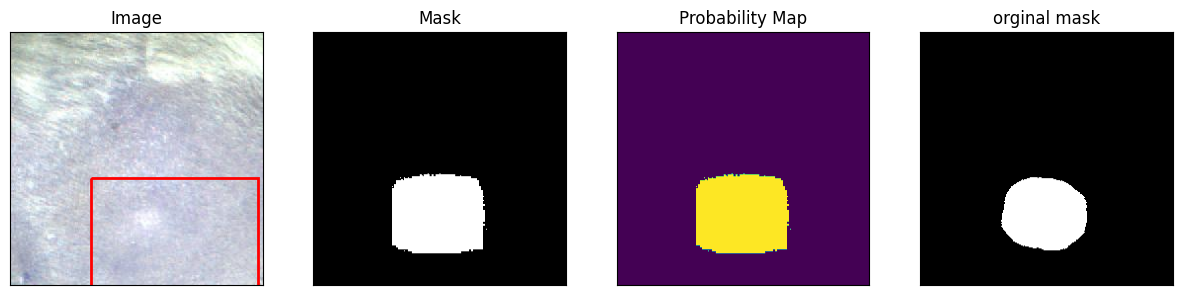

In [29]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# let's take a random training example
idx = random.randint(0, len(testing_raw))

# load image
test_image = testing_raw[idx]

# get box prompt based on ground truth segmentation map
ground_truth_mask = testing_masks[idx]

# test bounding box 
#bbox = [0,0,256,256]

# test with pointer prompt 
#pointer_prompt = [128,128]

prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 4, figsize=(15, 5))

bbox = prompt  # Assuming prompt is the bounding box coordinates
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask
axes[3].imshow(testing_masks[idx], cmap = "gray")
axes[3].set_title("orginal mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## Finding Patterns with a bad bounding box

In [7]:
# random image 
rand = random.randint(0, len(testing_raw))
image = testing_raw[rand]
mask = testing_masks[rand] 

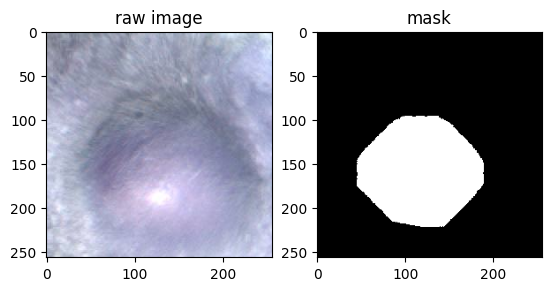

In [8]:
# now display that image

fig, ax = plt.subplots(1,2) 

ax[0].imshow(image)
ax[0].set_title('raw image') 

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('mask') 

plt.show()

Text(0.5, 1.0, 'Orignal Mask')

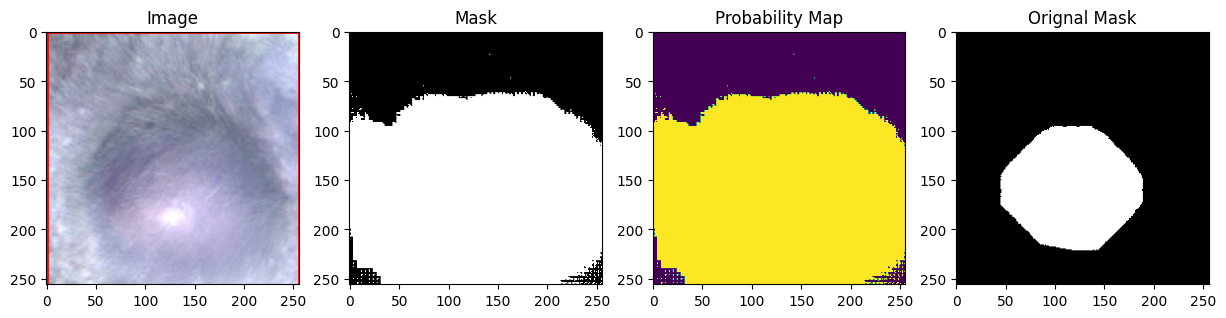

In [9]:
# get the input 
bbox = [0, 0, 256, 256]

# bbox = get_bounding_box(mask)

# prepare image
inputs = processor(image, input_boxes=[[bbox]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1,4, figsize=(15, 5)) 

# Plot the first image on the left
axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask 
axes[3].imshow(mask, cmap="gray") 
axes[3].set_title("Orignal Mask")



## Finding Patterns for Points

In [32]:
# random image 
rand = random.randint(0, len(testing_raw) -1)
image = testing_raw[rand]
mask = testing_masks[rand] 

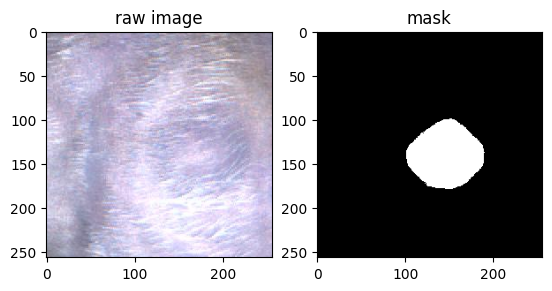

In [33]:
# now display that image

fig, ax = plt.subplots(1,2) 

ax[0].imshow(image)
ax[0].set_title('raw image') 

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('mask') 

plt.show()

Text(0.5, 1.0, 'Orignal Mask')

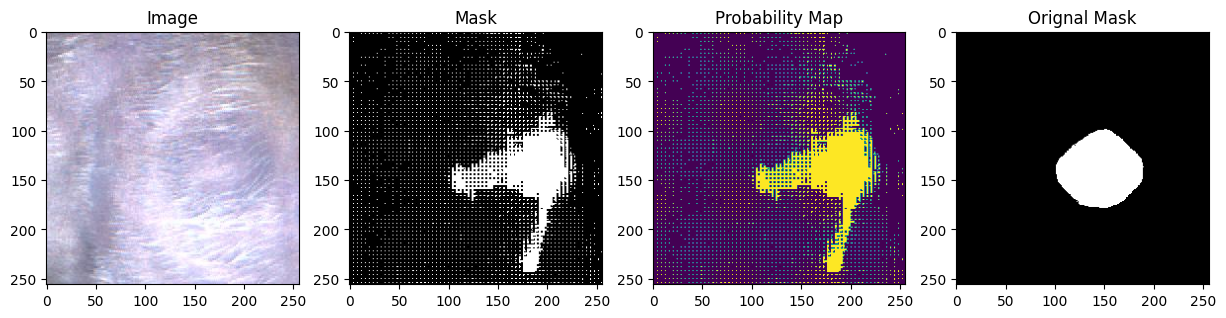

In [34]:
# get the input 
point = [200,150]

# prepare image
inputs = processor(image, input_points=[[point]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1,4, figsize=(15, 5)) 

# Plot the first image on the left
axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

bbox = point  # Assuming prompt is the bounding box coordinates
# rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
# axes[0].add_patch(rect)

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask 
axes[3].imshow(mask, cmap="gray") 
axes[3].set_title("Orignal Mask")

## Side by side bounding box and point 

In [80]:
# random image 
rand = random.randint(0, len(testing_raw) -1)
image = testing_raw[rand]
mask = testing_masks[rand] 

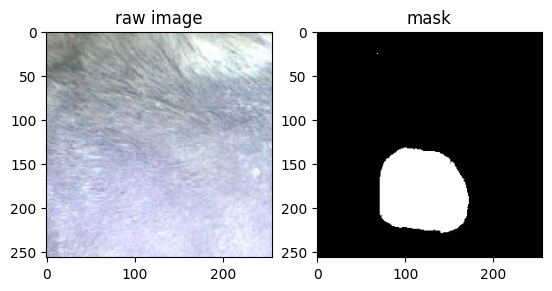

In [81]:
# now display that image

fig, ax = plt.subplots(1,2) 

ax[0].imshow(image)
ax[0].set_title('raw image') 

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('mask') 

plt.show()

Text(0.5, 1.0, 'Orignal Mask')

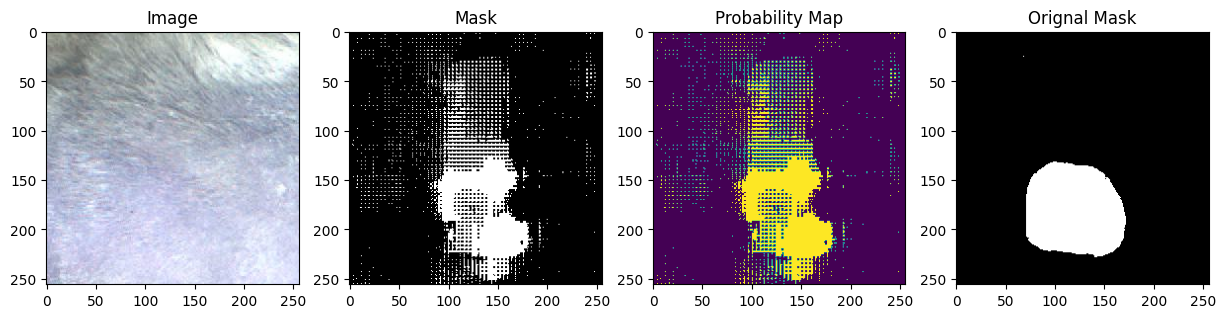

In [82]:
# get the inputs
point = [100,150]
bbox = get_bounding_box(mask)

# prepare image
inputs_point = processor(image, input_points=[[point]], return_tensors="pt")
inputs_bbox = processor(image, input_boxes=[[bbox]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs_point = {k: v.to(device) for k, v in inputs_point.items()}
inputs_bbox = {k: v.to(device) for k, v in inputs_bbox.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs_point = my_mito_model(**inputs_point, multimask_output=False)
    outputs_bbox = my_mito_model(**inputs_bbox, multimask_output=False)

# apply sigmoid
medsam_seg_prob_point = torch.sigmoid(outputs_point.pred_masks.squeeze(1))
medsam_seg_prob_bbox = torch.sigmoid(outputs_bbox.pred_masks.squeeze(1))


# convert soft mask to hard mask
medsam_seg_prob_point = medsam_seg_prob_point.cpu().numpy().squeeze()
medsam_seg_prob_bbox = medsam_seg_prob_bbox.cpu().numpy().squeeze()

medsam_seg_point = (medsam_seg_prob_point > 0.5).astype(np.uint8)
medsam_seg_bbox = (medsam_seg_prob_bbox > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1,4, figsize=(15, 5)) 

# Plot the first image on the left
axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

bbox = point  # Assuming prompt is the bounding box coordinates
# rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
# axes[0].add_patch(rect)

# Plot the second image on the right
axes[1].imshow(medsam_seg_point, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob_point)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask 
axes[3].imshow(mask, cmap="gray") 
axes[3].set_title("Orignal Mask")

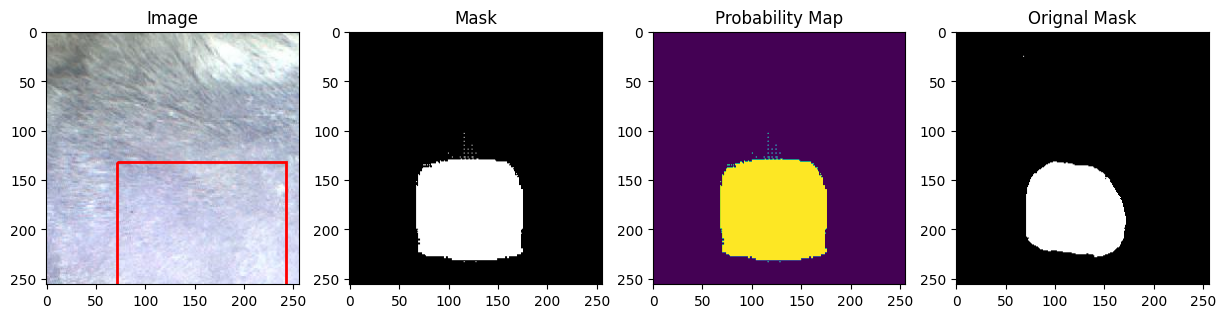

In [83]:
bbox = get_bounding_box(mask)

fig, axes = plt.subplots(1,4, figsize=(15,5))

# Plot the first image on the left
axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Plot the second image on the right
axes[1].imshow(medsam_seg_bbox, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob_bbox)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the original mask 
axes[3].imshow(mask, cmap="gray") 
axes[3].set_title("Orignal Mask")

plt.show()